#### Task-2: Data Exploration

## Importing Required Libraries

This section imports all the necessary Python libraries used for:
- Numerical computations
- Data handling
- Image processing
- Visualization
- Deep learning and evaluation

Libraries such as TensorFlow, Keras, NumPy, Pandas, Matplotlib, and Scikit-learn are used throughout the notebook.


In [78]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime




## Dataset Paths and Initialization

Here we define the directory paths for the training and testing datasets.
The dataset is organized into class-specific subfolders, which allows Keras
to automatically assign labels based on folder names.


In [79]:

# Path to training data
train_dir = "dataset/Training"

# Get class names
classes = sorted([
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
])

print("Classes:", classes)
print("Number of classes:", len(classes))

# Containers
class_instances = {}
unique_attributes = {
    'shapes': {},
    'mode': {}
}

# Loop through classes and images
for each_class in classes:
    class_dir = os.path.join(train_dir, each_class)

    image_files = [
        f for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    # Count images per class
    class_instances[each_class] = len(image_files)

    for img_file in image_files:
        img_path = os.path.join(class_dir, img_file)
        with Image.open(img_path) as img:

            # Count image shapes (width, height)
            shape = str(img.size)
            unique_attributes['shapes'][shape] = \
                unique_attributes['shapes'].get(shape, 0) + 1

            # Count image modes (RGB, L, etc.)
            mode = img.mode
            unique_attributes['mode'][mode] = \
                unique_attributes['mode'].get(mode, 0) + 1

# --------- TABLES ---------

# Images per class table
class_table = pd.DataFrame(
    class_instances.items(),
    columns=["Class", "Number of Images"]
)

# Image shape table
shape_table = pd.DataFrame(
    unique_attributes['shapes'].items(),
    columns=["Image Shape (W, H)", "Count"]
).sort_values(by="Count", ascending=False)

# Image mode table
mode_table = pd.DataFrame(
    unique_attributes['mode'].items(),
    columns=["Image Mode", "Count"]
)

# Display tables
print("\nImages per Class")
display(class_table)

print("\nImage Shapes")
display(shape_table)

print("\nImage Modes")
display(mode_table)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of classes: 4

Images per Class


,Class,Number of Images
0,glioma,1321
1,meningioma,1339
2,notumor,1595
3,pituitary,1457



Image Shapes


,"Image Shape (W, H)",Count
0,"(512, 512)",3955
83,"(225, 225)",268
126,"(630, 630)",77
142,"(236, 236)",53
86,"(201, 251)",43
...,...,...
188,"(255, 236)",1
189,"(233, 218)",1
42,"(312, 401)",1
1,"(503, 369)",1



Image Modes


,Image Mode,Count
0,RGB,3236
1,L,2472
2,RGBA,3
3,P,1


In [81]:

def train_df(tr_path):

    classes = []
    class_paths = []

    for label in sorted(os.listdir(tr_path)):
        class_dir = os.path.join(tr_path, label)

        if os.path.isdir(class_dir):
            for image in sorted(os.listdir(class_dir)):
                if image.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, image)
                    class_paths.append(img_path)
                    classes.append(label)

    tr_df = pd.DataFrame({
        'Image Path': class_paths,
        'Class': classes
    })

    return tr_df


In [82]:

def test_df(ts_path):

    classes = []
    class_paths = []

    for label in sorted(os.listdir(ts_path)):
        class_dir = os.path.join(ts_path, label)

        if os.path.isdir(class_dir):
            for image in sorted(os.listdir(class_dir)):
                if image.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, image)
                    class_paths.append(img_path)
                    classes.append(label)

    ts_df = pd.DataFrame({
        'Image Path': class_paths,
        'Class': classes
    })

    return ts_df


In [83]:

tr_df = train_df(train_dir)

tr_df

,Image Path,Class
0,dataset/Training\glioma\Tr-glTr_0000.jpg,glioma
1,dataset/Training\glioma\Tr-glTr_0001.jpg,glioma
2,dataset/Training\glioma\Tr-glTr_0002.jpg,glioma
3,dataset/Training\glioma\Tr-glTr_0003.jpg,glioma
4,dataset/Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,dataset/Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,dataset/Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,dataset/Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,dataset/Training\pituitary\Tr-pi_1455.jpg,pituitary


In [84]:
test_dir = "dataset/Testing"

ts_df = test_df(test_dir)

ts_df


,Image Path,Class
0,dataset/Testing\glioma\Te-glTr_0000.jpg,glioma
1,dataset/Testing\glioma\Te-glTr_0001.jpg,glioma
2,dataset/Testing\glioma\Te-glTr_0002.jpg,glioma
3,dataset/Testing\glioma\Te-glTr_0003.jpg,glioma
4,dataset/Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,dataset/Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,dataset/Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,dataset/Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,dataset/Testing\pituitary\Te-pi_0298.jpg,pituitary


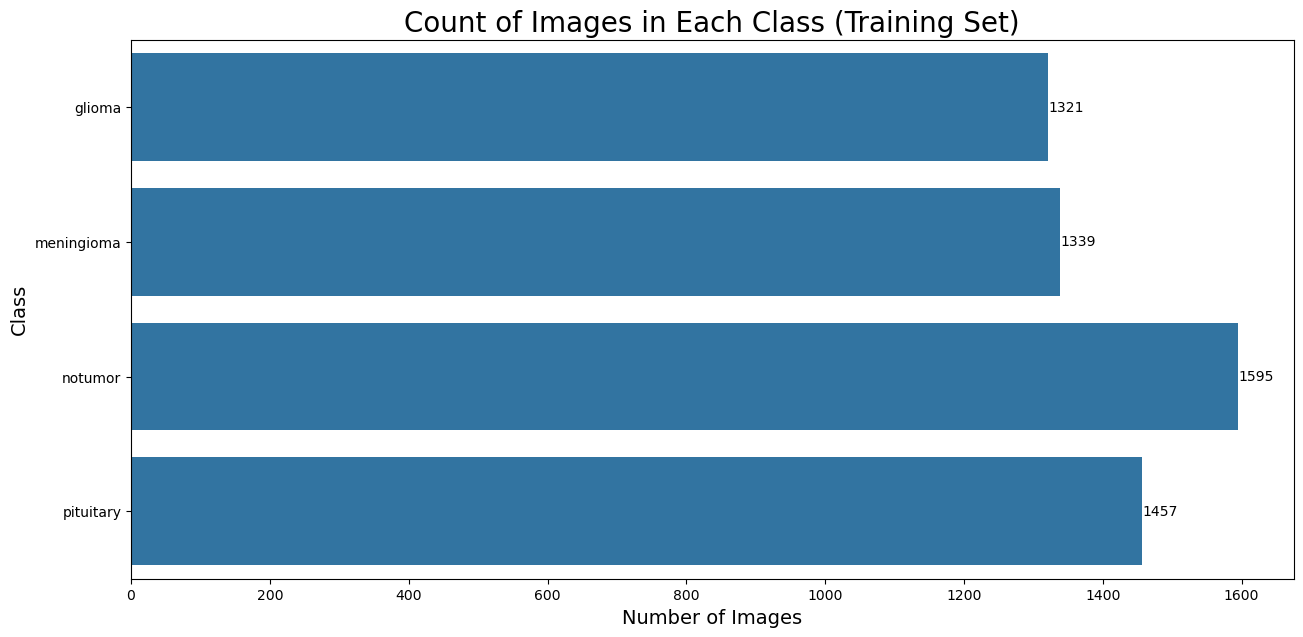

In [85]:

# Count of images in each class in train data
plt.figure(figsize=(15, 7))

# Plot number of images per class
ax = sns.countplot(data=tr_df, y='Class')

# Adjust axis labels and title
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Class', fontsize=14)
plt.title('Count of Images in Each Class (Training Set)', fontsize=20)

# Show counts on the bars
ax.bar_label(ax.containers[0])

plt.show()


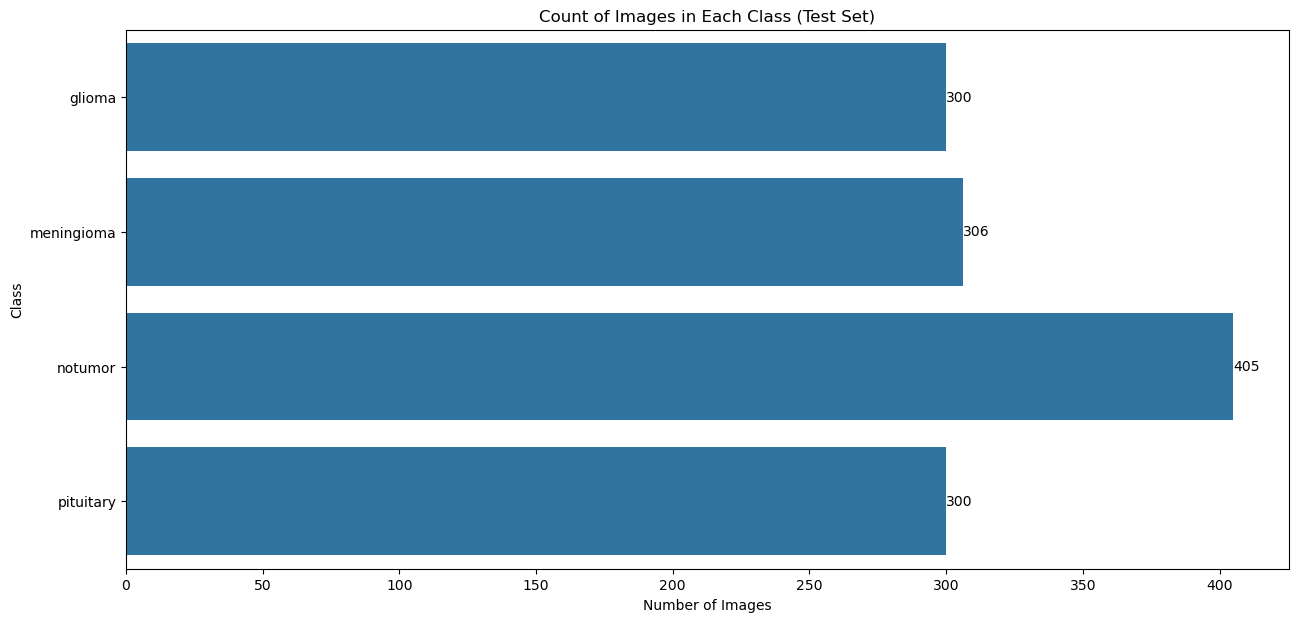

In [86]:

# Count each class in test data
plt.figure(figsize=(15, 7))

# Plot number of images per class in TEST set
ax = sns.countplot(y=ts_df['Class'])

# Adjust labels and title
ax.set(
    xlabel='Number of Images',
    ylabel='Class',
    title='Count of Images in Each Class (Test Set)'
)

# Add bar labels
ax.bar_label(ax.containers[0])

plt.show()


In [87]:

valid_df, ts_df = train_test_split(
    ts_df,
    train_size=0.2,
    random_state=20,
    stratify=ts_df['Class']
)


## Image Preprocessing and Data Augmentation

In this section:
- Images are resized to 128×128 pixels
- Pixel values are normalized
- Data augmentation techniques such as rotation, zoom, and flipping are applied

Data augmentation helps improve generalization and reduce overfitting.


In [88]:


batch_size = 8
img_size = (128, 128)

gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

ts_gen = ImageDataGenerator(rescale=1/255)


## Creating Data Generators

Keras ImageDataGenerator is used to:
- Load images from directories
- Apply real-time data augmentation
- Split training data into training and validation sets

Batch size is set to 8.


In [89]:
# Training generator (with augmentation)
tr_gen = gen.flow_from_dataframe(
    tr_df,
    x_col='Image Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size,
    class_mode='categorical'
)

# Validation generator (NO augmentation)
valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='Image Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size,
    class_mode='categorical',
    shuffle=False
)


Found 5712 validated image filenames belonging to 4 classes.
Found 262 validated image filenames belonging to 4 classes.


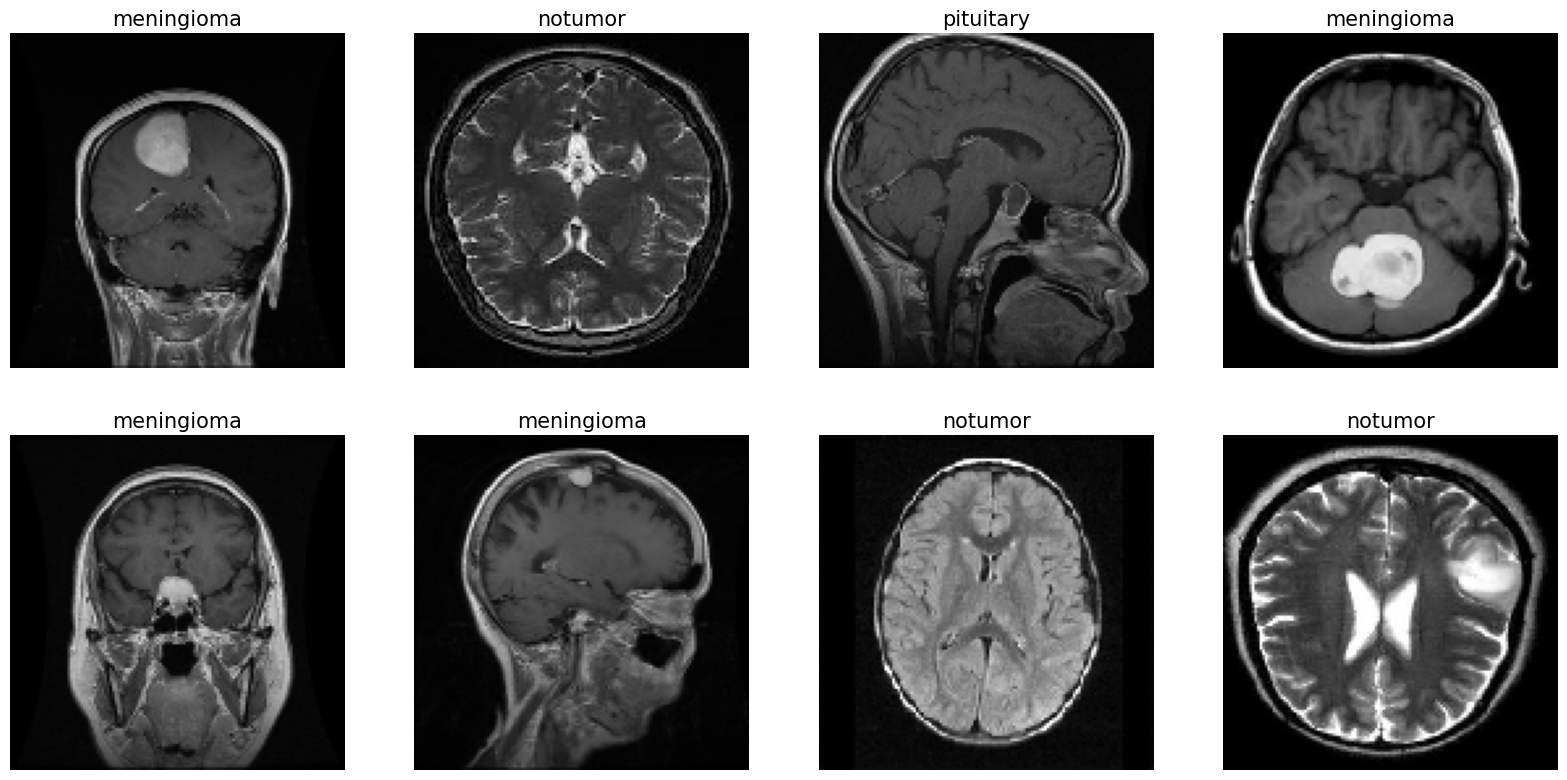

In [90]:

# Dictionary mapping class names to indices
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())

# Fetch a batch of images and labels from the VALIDATION generator
images, labels = next(valid_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, i + 1)

    # Display the image
    plt.imshow(image)

    # Convert one-hot label to class name
    class_name = classes[np.argmax(label)]

    plt.title(class_name, color='k', fontsize=15)
    plt.axis('off')

plt.show()


In [91]:
# Define image shape (matches generators)
img_shape = (128, 128, 3)

# Build a simple CNN model
model = Sequential([
    # First convolution + pooling block
    Conv2D(32, (3,3), activation='relu', input_shape=img_shape),
    MaxPooling2D(pool_size=(2,2)),

    # Second convolution + pooling block
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer – number of units must match number of classes
    Dense(4, activation='softmax')
])

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()

# TensorBoard callback
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fit the model (training generator first, validation second)
history = model.fit(
    tr_gen,                  # training generator
    validation_data=valid_gen,   # validation generator
    epochs=35,
    callbacks=[tensorboard_callback, early_stopping_callback]
)


c:\Users\klena\anaconda3\envs\bmi_lab\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,836 (28.20 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 168s 224ms/step - accuracy: 0.6766 - loss: 0.8018 - precision_7: 0.7743 - recall_7: 0.5389 - val_accuracy: 0.7137 - val_loss: 0.9554 - val_precision_7: 0.7479 - val_recall_7: 0.6794
Epoch 2/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 174s 242ms/step - accuracy: 0.7749 - loss: 0.5730 - precision_7: 0.8104 - recall_7: 0.7267 - val_accuracy: 0.6947 - val_loss: 1.0333 - val_precision_7: 0.7362 - val_recall_7: 0.6603
Epoch 3/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 256s 317ms/step - accuracy: 0.8092 - loss: 0.4907 - precision_7: 0.8384 - recall_7: 0.7721 - val_accuracy: 0.7481 - val_loss: 0.6919 - val_precision_7: 0.7967 - val_recall_7: 0.7328
Epoch 4/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 234s 327ms/step - accuracy: 0.8277 - loss: 0.4526 - precision_7: 0.8463 - recall_7: 0.7981 - val_accuracy: 0.7481 - val_loss: 0.8744 - val_precision_7: 0.7673 - val_recall_7: 0.7176
Epoch 5/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 137s 192ms/step - accuracy: 0.8451 - loss: 0.4110 - precision_7: 0.8652 

###                                      Model  saving

####      Calculation of Metrics (Accuracy, Confusion Matrix, Sensitivity, Specificity, F1-score)

Found 1049 validated image filenames belonging to 4 classes.
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 334ms/step
Accuracy: 0.9323164918970448
Precision: 0.9359824944803741
Recall (Sensitivity): 0.9266369047619047
F1-score: 0.9291038467331476


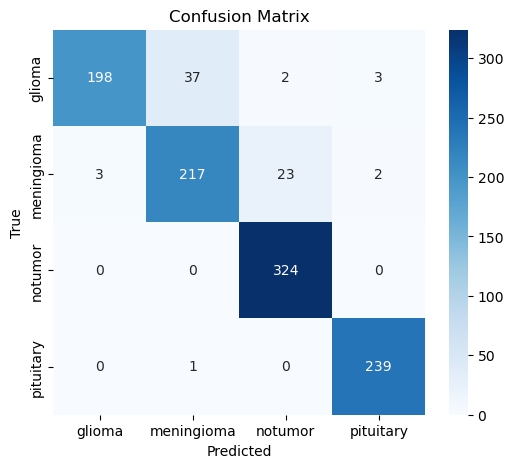


Sensitivity & Specificity per class:
glioma: Sensitivity=0.8250, Specificity=0.9963
meningioma: Sensitivity=0.8857, Specificity=0.9527
notumor: Sensitivity=1.0000, Specificity=0.9655
pituitary: Sensitivity=0.9958, Specificity=0.9938

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.82      0.90       240
  meningioma       0.85      0.89      0.87       245
     notumor       0.93      1.00      0.96       324
   pituitary       0.98      1.00      0.99       240

    accuracy                           0.93      1049
   macro avg       0.94      0.93      0.93      1049
weighted avg       0.93      0.93      0.93      1049



In [97]:
# ===============================
# 1. Create TEST generator
# ===============================

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

test_gen = ts_gen.flow_from_dataframe(
    ts_df,
    x_col='Image Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ===============================
# 2. Get predictions
# ===============================
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())

# ===============================
# 3. Metrics
# ===============================
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')   # Sensitivity
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1-score:", f1)

# ===============================
# 4. Confusion Matrix
# ===============================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ===============================
# 5. Sensitivity & Specificity (per class)
# ===============================
print("\nSensitivity & Specificity per class:")

for i, cls in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    print(f"{cls}: Sensitivity={sensitivity:.4f}, Specificity={specificity:.4f}")

# ===============================
# 6. Full classification report
# ===============================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


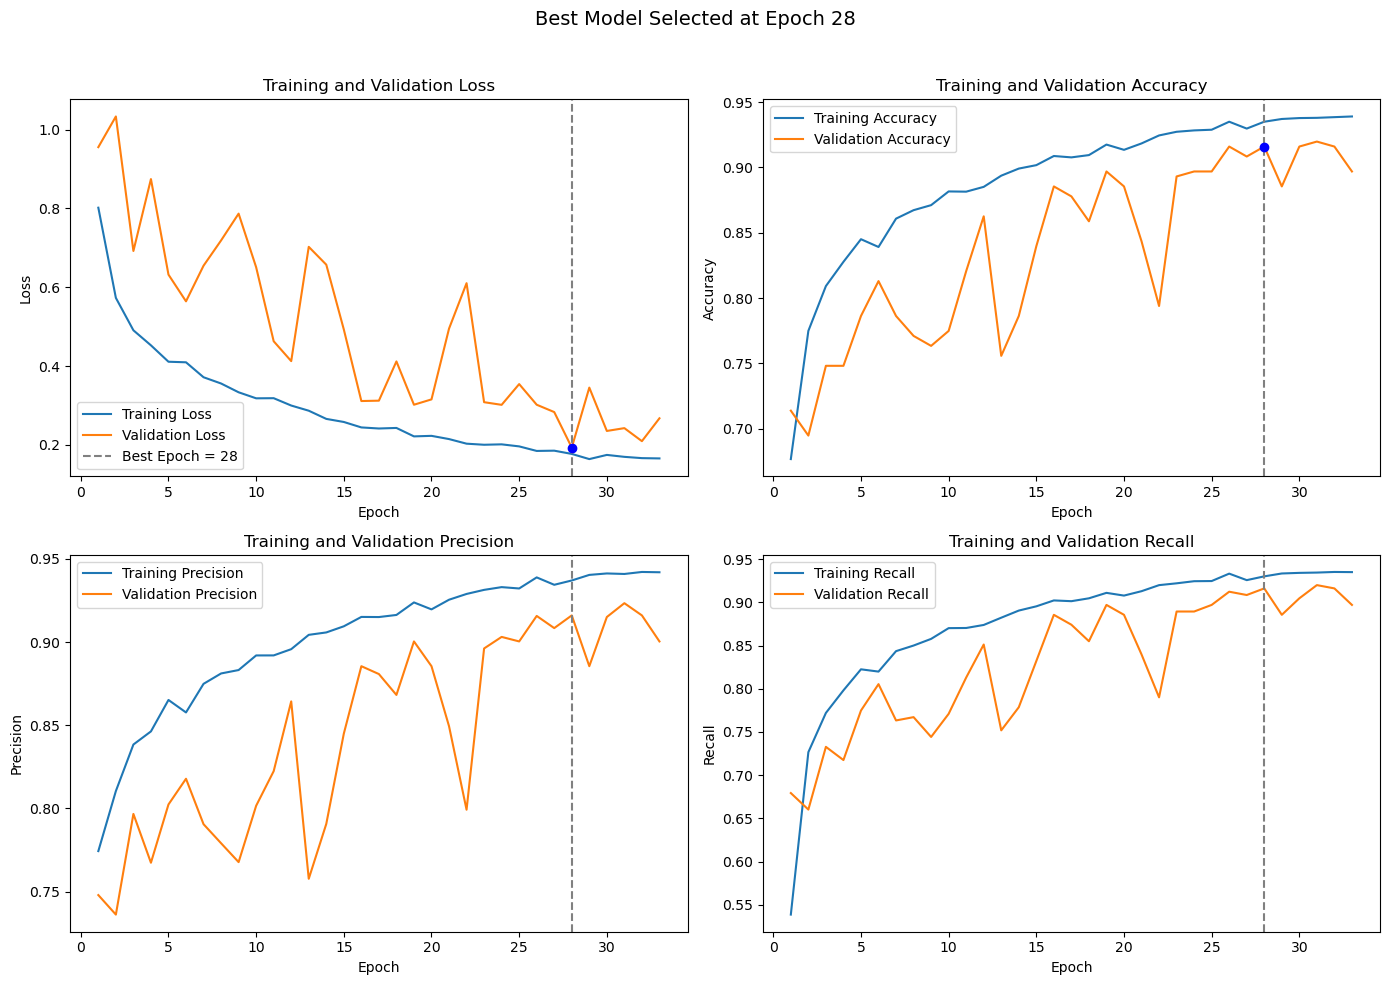

In [98]:

# Epochs
epochs = np.arange(1, len(history.history['loss']) + 1)

# 1️⃣ Find best epoch based on validation loss
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = history.history['val_loss'][best_epoch - 1]
best_val_acc = history.history['val_accuracy'][best_epoch - 1]

# Automatically find precision & recall keys
precision_key = [k for k in history.history if 'precision' in k and not k.startswith('val')][0]
val_precision_key = [k for k in history.history if 'val' in k and 'precision' in k][0]
recall_key = [k for k in history.history if 'recall' in k and not k.startswith('val')][0]
val_recall_key = [k for k in history.history if 'val' in k and 'recall' in k][0]

plt.figure(figsize=(14,10))

# 🔹 Loss
plt.subplot(2,2,1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.axvline(best_epoch, linestyle='--', color='gray', label=f'Best Epoch = {best_epoch}')
plt.scatter(best_epoch, best_val_loss, color='blue', zorder=5)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 🔹 Accuracy
plt.subplot(2,2,2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(best_epoch, linestyle='--', color='gray')
plt.scatter(best_epoch, best_val_acc, color='blue', zorder=5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 🔹 Precision
plt.subplot(2,2,3)
plt.plot(epochs, history.history[precision_key], label='Training Precision')
plt.plot(epochs, history.history[val_precision_key], label='Validation Precision')
plt.axvline(best_epoch, linestyle='--', color='gray')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# 🔹 Recall
plt.subplot(2,2,4)
plt.plot(epochs, history.history[recall_key], label='Training Recall')
plt.plot(epochs, history.history[val_recall_key], label='Validation Recall')
plt.axvline(best_epoch, linestyle='--', color='gray')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.suptitle(f'Best Model Selected at Epoch {best_epoch}', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### A transfer learning approach using the ResNet50 architecture was employed to improve classification performance. ResNet50 was chosen due to its deep residual structure, which enables effective feature extraction from medical images while avoiding vanishing gradient issues. Pretrained ImageNet weights were used, and the base layers were frozen to reduce overfitting and computational cost.


In [99]:
import os
import datetime
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

img_shape = (128, 128, 3)

# Load ResNet50 base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape
)

# Freeze base model layers (important)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()

# TensorBoard callback
log_dir = os.path.join(
    "logs",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model

history = model.fit(
    tr_gen,
    validation_data=valid_gen,
    epochs=35,
    callbacks=[tensorboard_callback, early_stopping_callback]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 122s 1us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 294s 394ms/step - accuracy: 0.2924 - loss: 1.3836 - precision_8: 0.6410 - recall_8: 0.0044 - val_accuracy: 0.3740 - val_loss: 1.2937 - val_precision_8: 1.0000 - val_recall_8: 0.0267
Epoch 2/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 233s 326ms/step - accuracy: 0.3815 - loss: 1.3078 - precision_8: 0.9358 - recall_8: 0.0306 - val_accuracy: 0.4542 - val_loss: 1.2381 - val_precision_8: 0.8462 - val_recall_8: 0.1260
Epoch 3/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 291s 407ms/step - accuracy: 0.4238 - loss: 1.2619 - precision_8: 0.9369 - recall_8: 0.0702 - val_accuracy: 0.5000 - val_loss: 1.2068 - val_precision_8: 0.8511 - val_recall_8: 0.1527
Epoch 4/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 207s 290ms/step - accuracy: 0.4596 - loss: 1.2277 - precision_8: 0.9278 - recall_8: 0.0989 - val_accuracy: 0.4847 - val_loss: 1.1864 - val_precision_8: 0.8400 - val_recall_8: 0.1603
Epoch 5/35
714/714 ━━━━━━━━━━━━━━━━━━━━ 215s 301ms/step - accuracy: 0.4900 - loss: 1.1955 - precision_8: 0.9343 

Found 1049 validated image filenames belonging to 4 classes.
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step
Accuracy: 0.6034318398474738
Precision: 0.5906628026473387
Recall (Sensitivity): 0.5844600340136055
F1-score: 0.5796434539183558


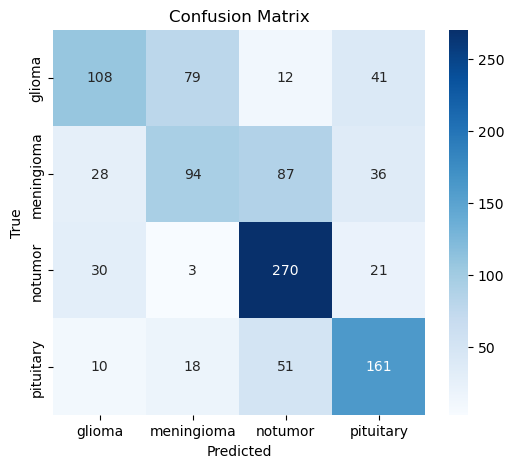


Sensitivity & Specificity per class:
glioma: Sensitivity=0.4500, Specificity=0.9159
meningioma: Sensitivity=0.3837, Specificity=0.8756
notumor: Sensitivity=0.8333, Specificity=0.7931
pituitary: Sensitivity=0.6708, Specificity=0.8789

Classification Report:
              precision    recall  f1-score   support

      glioma       0.61      0.45      0.52       240
  meningioma       0.48      0.38      0.43       245
     notumor       0.64      0.83      0.73       324
   pituitary       0.62      0.67      0.65       240

    accuracy                           0.60      1049
   macro avg       0.59      0.58      0.58      1049
weighted avg       0.59      0.60      0.59      1049



In [100]:
# ===============================
# 1. Create TEST generator
# ===============================

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

test_gen = ts_gen.flow_from_dataframe(
    ts_df,
    x_col='Image Path',
    y_col='Class',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ===============================
# 2. Get predictions
# ===============================
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

class_names = list(test_gen.class_indices.keys())

# ===============================
# 3. Metrics
# ===============================
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')   # Sensitivity
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("F1-score:", f1)

# ===============================
# 4. Confusion Matrix
# ===============================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ===============================
# 5. Sensitivity & Specificity (per class)
# ===============================
print("\nSensitivity & Specificity per class:")

for i, cls in enumerate(class_names):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    print(f"{cls}: Sensitivity={sensitivity:.4f}, Specificity={specificity:.4f}")

# ===============================
# 6. Full classification report
# ===============================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


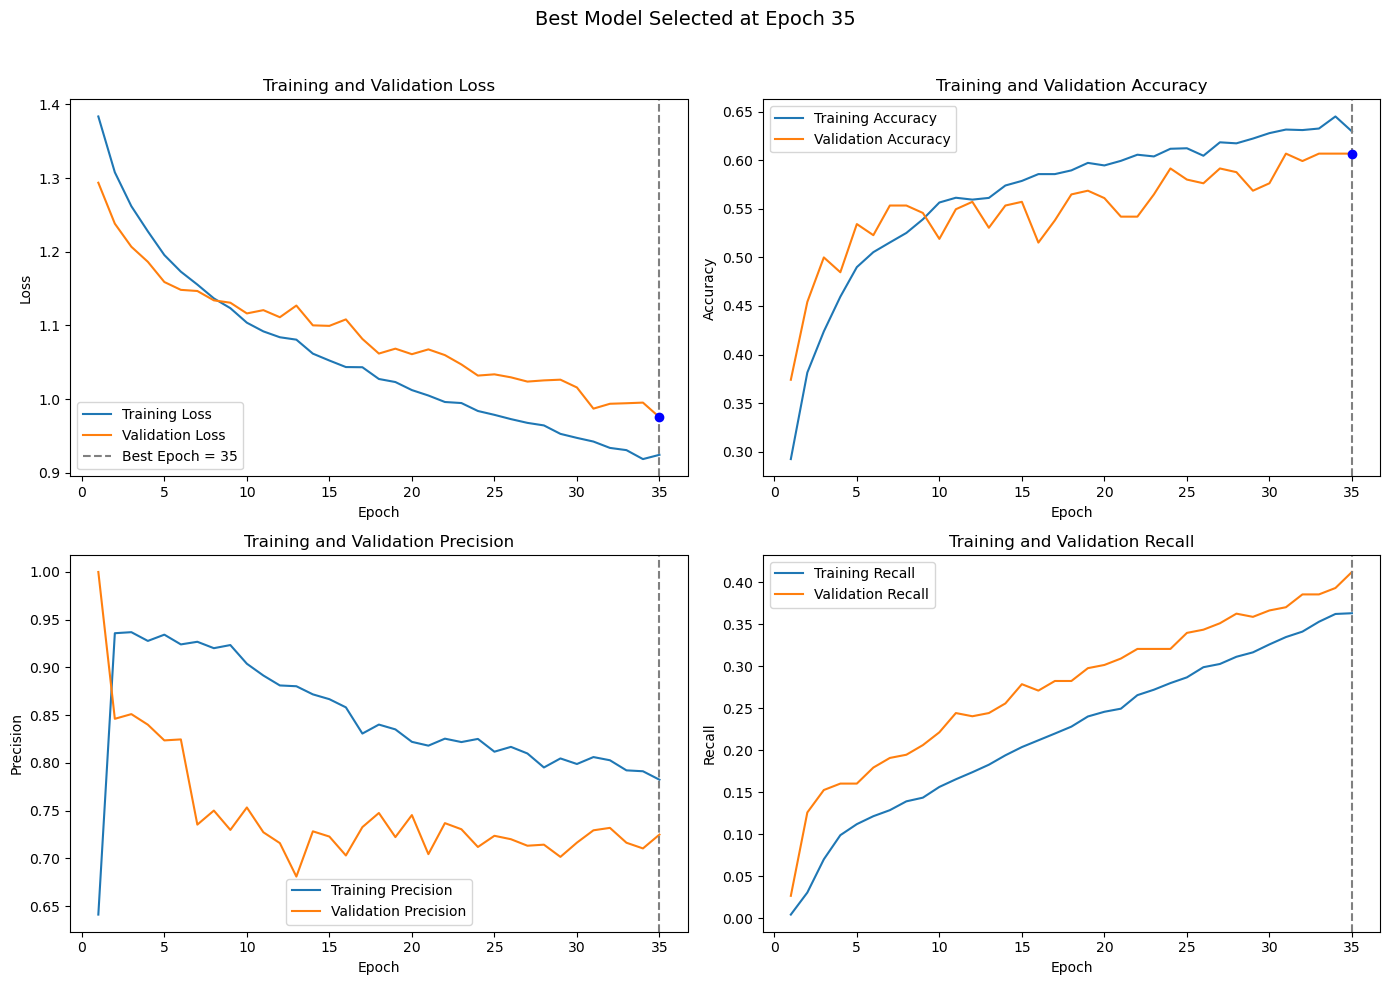

In [101]:

# Epochs
epochs = np.arange(1, len(history.history['loss']) + 1)

# 1️⃣ Find best epoch based on validation loss
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = history.history['val_loss'][best_epoch - 1]
best_val_acc = history.history['val_accuracy'][best_epoch - 1]

# Automatically find precision & recall keys
precision_key = [k for k in history.history if 'precision' in k and not k.startswith('val')][0]
val_precision_key = [k for k in history.history if 'val' in k and 'precision' in k][0]
recall_key = [k for k in history.history if 'recall' in k and not k.startswith('val')][0]
val_recall_key = [k for k in history.history if 'val' in k and 'recall' in k][0]

plt.figure(figsize=(14,10))

# 🔹 Loss
plt.subplot(2,2,1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.axvline(best_epoch, linestyle='--', color='gray', label=f'Best Epoch = {best_epoch}')
plt.scatter(best_epoch, best_val_loss, color='blue', zorder=5)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 🔹 Accuracy
plt.subplot(2,2,2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(best_epoch, linestyle='--', color='gray')
plt.scatter(best_epoch, best_val_acc, color='blue', zorder=5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 🔹 Precision
plt.subplot(2,2,3)
plt.plot(epochs, history.history[precision_key], label='Training Precision')
plt.plot(epochs, history.history[val_precision_key], label='Validation Precision')
plt.axvline(best_epoch, linestyle='--', color='gray')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# 🔹 Recall
plt.subplot(2,2,4)
plt.plot(epochs, history.history[recall_key], label='Training Recall')
plt.plot(epochs, history.history[val_recall_key], label='Validation Recall')
plt.axvline(best_epoch, linestyle='--', color='gray')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.suptitle(f'Best Model Selected at Epoch {best_epoch}', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
